# Forecasting Sales with Machine Learning Models 

Forecasting is the process of analyzing **historical data** using statistics and modeling to **predict future values**. 

Machine learning is field of AI that uses **statistical techniques** to give computer systems the **ability to learn** e.g. progressively improve performance on a specific task from data, without being explicitly programmed.

In [0]:
%pip install xgboost tensorflow -q

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Import Python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import mlflow

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from pyspark.sql.functions import col, collect_list, struct
from pyspark.sql.window import Window

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2024-07-25 16:06:47.986483: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 16:06:47.992427: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 16:06:48.008653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 16:06:48.035368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 16:06:48.042795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 16:06:48.063361: I tensorflow/core/platform/cpu_feature_gu

## I. Data Preprocessing and Feature Engineering
**Data preprocessing** involves cleaning and preparing raw data to facilitate feature engineering. 
- **Normalization** is the process of scaling numeric features to a standard range, typically between 0 and 1. This ensures that all features contribute equally to the model.
- **Categorical data** needs to be converted into numerical format for machine learning algorithms. Encoding techniques them into a format that algorithms can understand.
- **Handling Missing Data** is essential for robust model performance. Strategies include removing rows with missing values or imputing missing values with statistical measures.

**Feature engineering** is the process of transforming and raw data into into a format suitable for machine learning models and selecting relevant features to optimize performance.

- **Creation of derived features** enhances the predictive power of the model.
- **Dimensionality reduction** is improtant because high-dimensional datasets may suffer from the curse of dimensionality, leading to increased computational complexity and potential overfitting. 
- **Handling outliers** prevents the distortion of model training. Techniques such as trimming or transforming features can mitigate the impact of outliers on model performance.

In [0]:
# Read the table from the CSV (comma-separated values) file in Unity Catalog 
df = spark.read.format("csv").option("delimiter", ",").table("hive_metastore.default.rossmann_stores_data")

# Convert Spark DataFrame to Pandas DataFrame
df = df.toPandas()

# Display the first 5 (default) rows of the DataFrame
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,479,4,2014-02-06,12918,1420,1,1,0,1
1,480,4,2014-02-06,5558,684,1,1,0,1
2,481,4,2014-02-06,6687,578,1,1,0,0
3,482,4,2014-02-06,7543,866,1,1,0,1
4,483,4,2014-02-06,5645,764,1,1,0,1


In [0]:
# Check for null values and determine the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [0]:
# Convert the 'Date' column to string type
df['Date'] = df['Date'].astype(str)

# Extract the year and week from the 'WeekSKID' column
df.loc[:, 'Year'] = df['Date'].str[:4].astype(int)
df.loc[:, 'Month'] = df['Date'].str[5:7].astype(int)
df.loc[:, 'Day'] = df['Date'].str[-2:].astype(int)

# Identify the categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_df = df[categorical_columns]
numerical_df = df[numerical_columns]
print(f"Categorical Columns:\n{categorical_columns}")
print(f"Numerical Columns:\n{numerical_columns}")

Categorical Columns:
['Date', 'StateHoliday']
Numerical Columns:
['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month', 'Day']


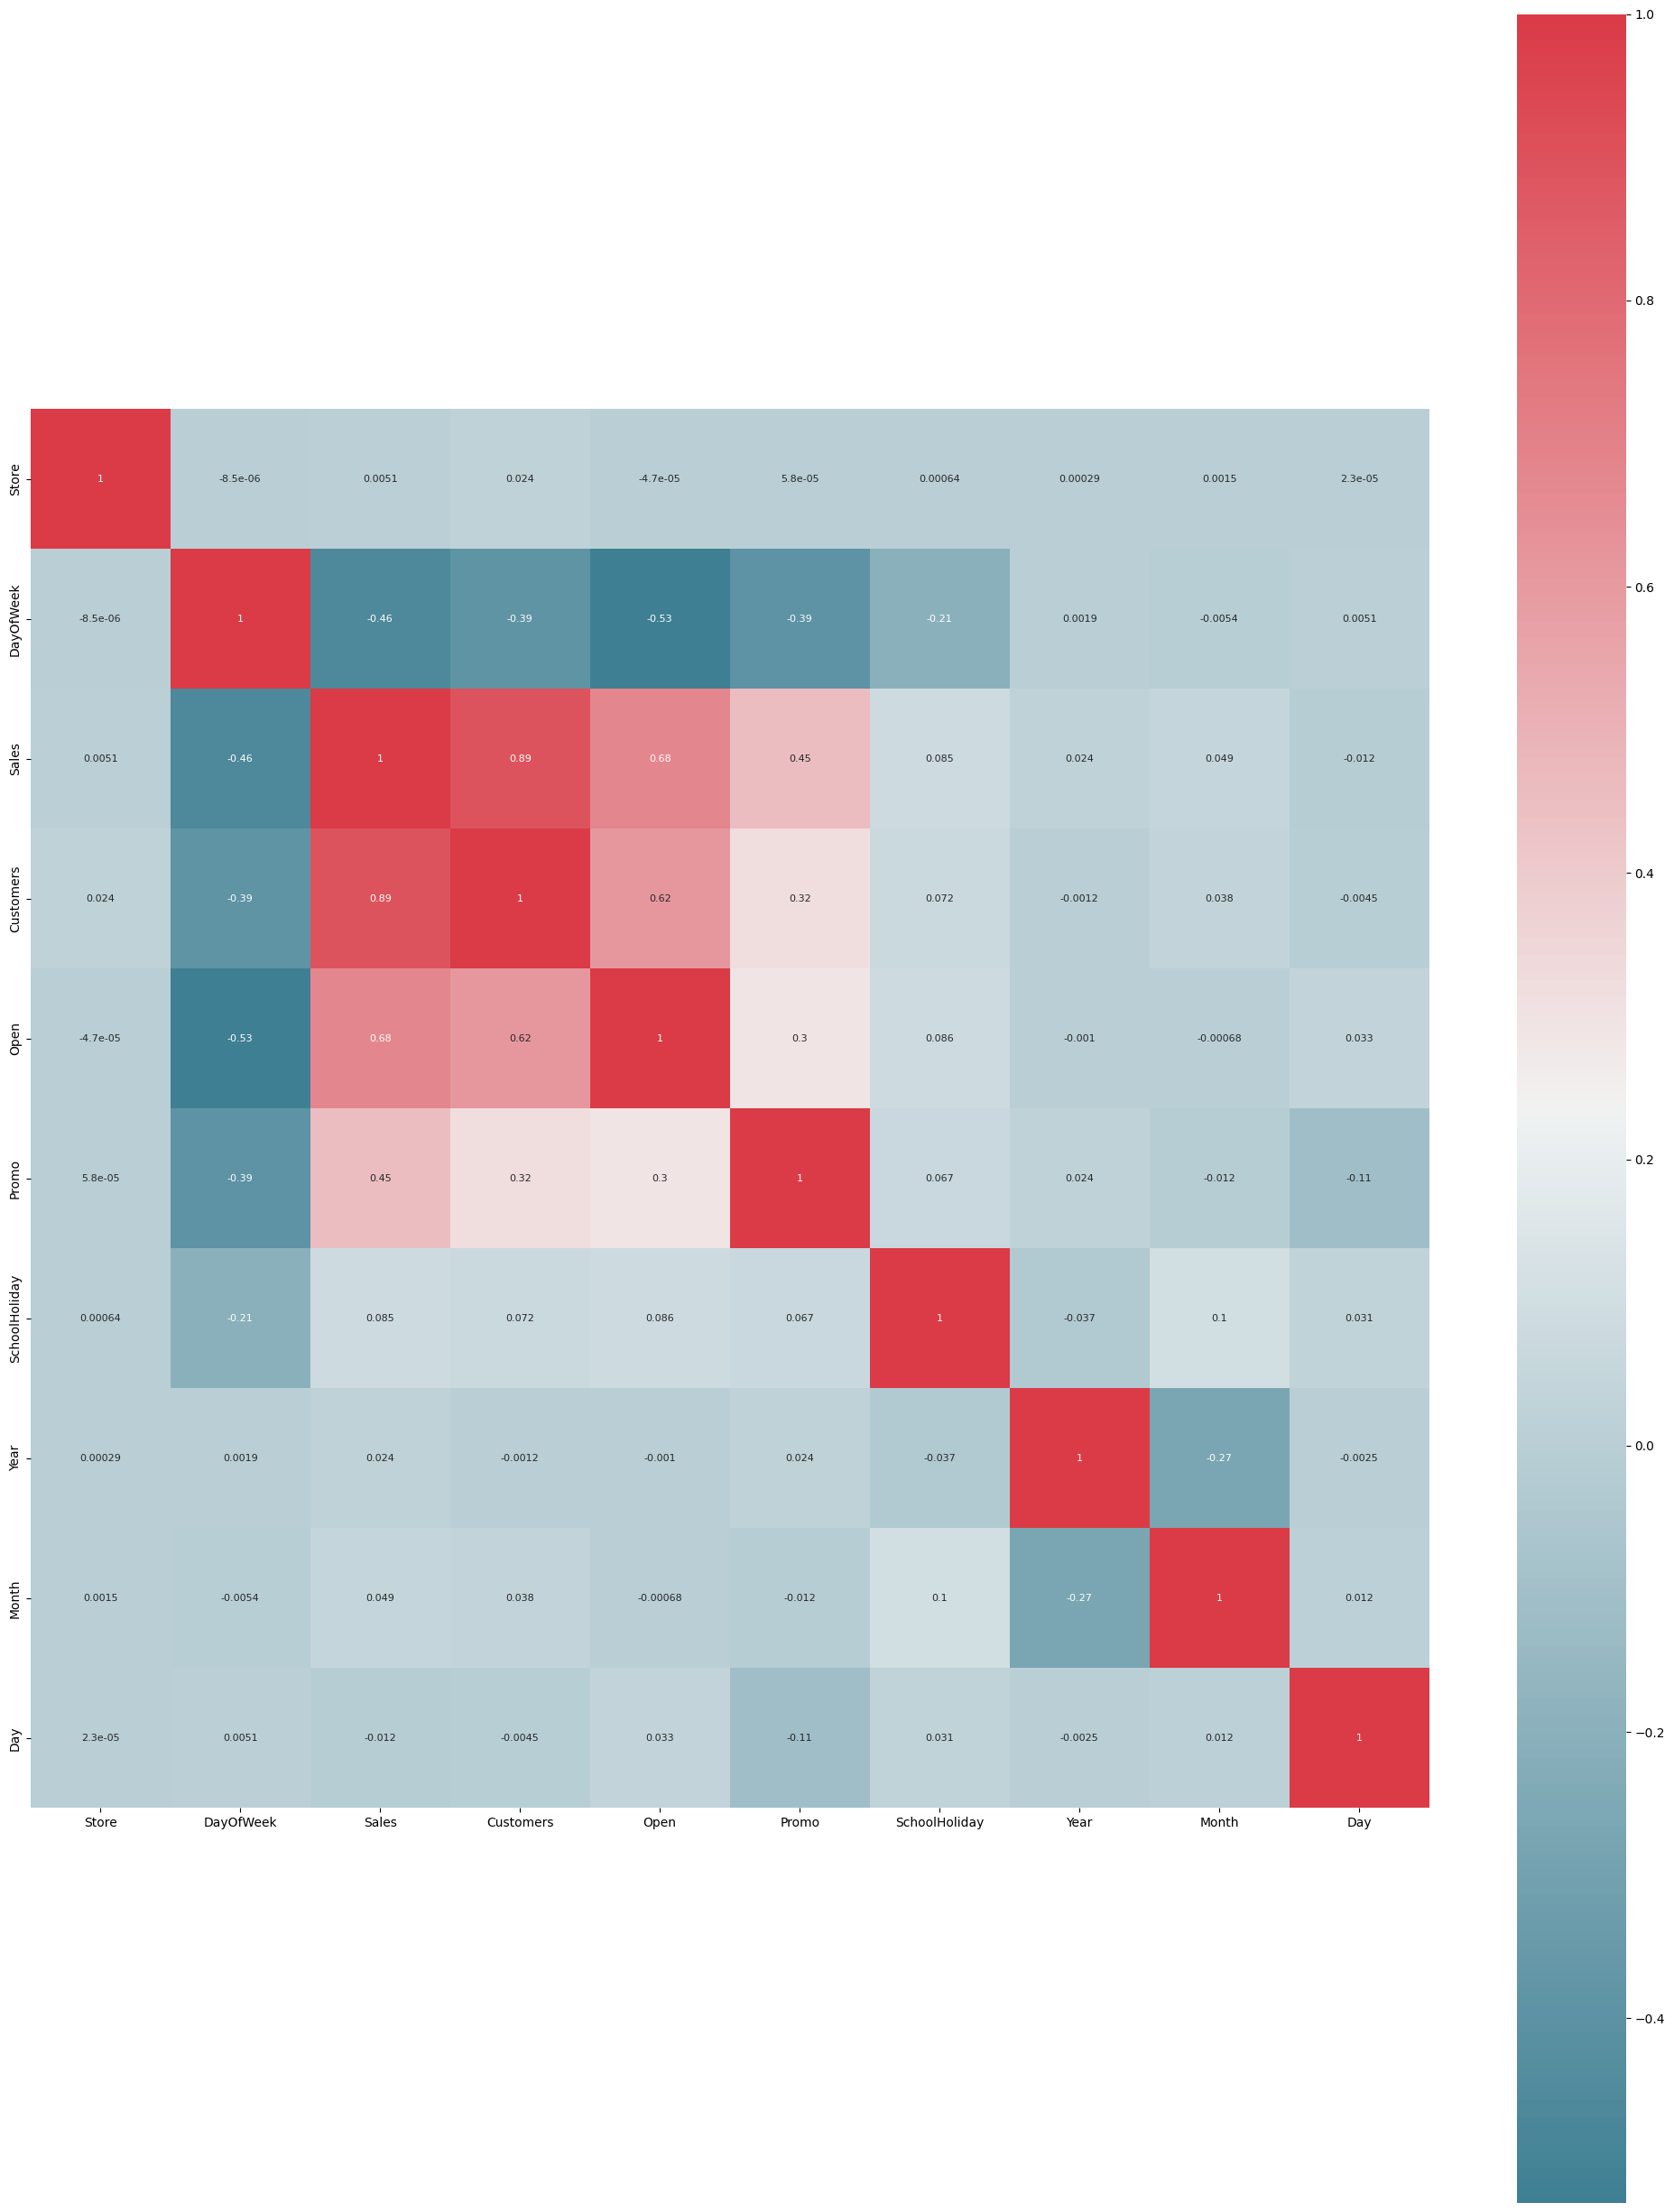

In [0]:
# Create a subplot with a figure size of 25 inches by 35 inches
color_map, axis = plt.subplots (figsize = (25,35))
# Calculate the correlation matrix for the specified numerical columns in the DataFrame' using Pearson's method
correlation_matrix = numerical_df.corr(method = 'pearson')
# Create a diverging color palette for the heatmap
# Create a heatmap to visualize the correlation matrix
# cmap - Use the diverging color palette created above
# square - Make the cells square
# cbar_kws - Add a color bar with a shrink factor of 0.9
# ax - Use the specified axis for the plot
# annot - Annotate the cells with the correlation values
# annot_kws - Set the font size for the annotations to 8
cmap = sns.diverging_palette(220,10, as_cmap = True)
_ = sns.heatmap (correlation_matrix, cmap = cmap, square = True, cbar_kws={
    'shrink' : .9}, ax=axis, annot = True, annot_kws = {'fontsize':8})

In [0]:
# Calculate correlations of the numerical data with the target column
correlations = df[numerical_columns].corrwith(df['Sales'])
# Rank the correlations by their absolute values
ranked_correlations = correlations.abs().sort_values(ascending=False)
# Display the ranked correlations
ranked_correlations

Sales            1.000000
Customers        0.894711
Open             0.678472
DayOfWeek        0.462125
Promo            0.452345
SchoolHoliday    0.085124
Month            0.048768
Year             0.023519
Day              0.011612
Store            0.005126
dtype: float64

In [0]:
# Preprocess the DataFrame and split it into the testing and training sets
def preprocess(df: pd.DataFrame, columns_to_drop: np.ndarray, one_hot_encoder_values: np.ndarray,numerical_values: np.ndarray, target_variable: np.ndarray):

    # Drop columns that are not needed
    df_model = df.drop(columns=columns_to_drop)

    # Replace 'null' strings with NaN values
    df_model.replace('null', np.nan, inplace=True)

    # Convert numerical columns to floats and ordinal columns to strings
    for column in numerical_values:
        df_model[column] = pd.to_numeric(df_model[column], errors='coerce')
    for column in one_hot_encoder_values:
        df_model[column] = df_model[column].astype(str)

    # Drop rows with missing values
    df_model = df_model.dropna(subset=one_hot_encoder_values + numerical_values + target_variable)

    # Ensure there are no infinite or excessively large values in numerical features and target
    df_model = df_model[np.isfinite(df_model[numerical_values + target_variable]).all(axis=1)]

    # Standardize the target variable helps to ensure that the target values have a mean of 0 and a standard deviation of 1
    target_scaler = StandardScaler()
    df_model[target_variable] = target_scaler.fit_transform(df_model[target_variable].values.reshape(-1, 1))

    # Define the preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_values),
            ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_encoder_values),
    ])

    # Split data into features (X) and target (y) and covert the latter to the correct shape
    X = df_model[one_hot_encoder_values + numerical_values]
    y = df_model[target_variable].values.ravel()

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the preprocessor and transform the training data and testing data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test, preprocessor, target_scaler

X_train, X_test, y_train, y_test, preprocessor, target_scaler = preprocess(df, columns_to_drop, one_hot_encoder_values, numerical_values, target_variable)

In [0]:
# Inverse transform the predictions and the target values to convert them back to their original scale
def postprocess(predictions, y_test, target_scaler):
    # Use the fitted scaler to inverse transform the predictions
    inverse_predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
    # Use the fitted scaler to inverse transform the test target values (y_test)
    inverse_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    # Return the inverse transformed predictions and test target values
    return inverse_predictions, inverse_y_test

## II. Building Machine Learning Models with Scikit-Learn
Scikit-Learn is a free **machine learning library** for Python. It supports both supervised and unsupervised machine learning, providing diverse algorithms for classification, regression, clustering, and dimensionality reduction.

In [0]:
# Calculate simple error
def _error(actual: np.ndarray, predicted: np.ndarray):
    return actual - predicted

# Calculate mean absolute error
def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_error(actual, predicted)), axis=0)

# Calculate mean squared error
def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(_error(actual, predicted)), axis=0)

# Calculate root mean squared error
def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))

# Calculate forecast bias (mean forecast error)
def bias(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(actual - predicted)

METRICS = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "bias": bias
}

# Create a function to evaluate the model based on each metric
def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "mse", "rmse", "bias")):
    results = {}
    for metric in metrics:
        try:
            results[metric] = METRICS[metric](actual, predicted)
        except Exception as err:
            results[metric] = np.nan
            print("ERROR Unable to compute {0}: {1}".format(metric, err))
    return results

# Initialize the dictionaries to store the results and predictions
results = {}
predictions = {}

### 1. Random Forest
A random forest is a machine learning algorithm that combines an ensemble of  **decision trees** (forest) to create a singular output. Each tree is constructed using a random subset of the data in order to measure a random subset of features within each partition. The algorithm aggregates the results of all the trees by taking their average.

![image](https://corporatefinanceinstitute.com/assets/random-forest-600x399.png)


In [0]:
def random_forest(X_train, X_test, y_train, y_test):
  # Initialize the RandomForestRegressor model with 100 trees, a maximum depth of 10, and a random state of 0
  rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10, 
    random_state=0
  )
  # Fit the RandomForestRegressor model to the training data
  rf_model.fit(X_train, y_train)
  # Predict the target values for the test data
  rf_predictions = rf_model.predict(X_test)
  # Inverse transform the predictions and the test target values using the postprocess function
  inverse_predictions, inverse_y_test = postprocess(rf_predictions, y_test, target_scaler)
  # Evaluate the model's performance and store the results
  results['RandomForest'] = evaluate(inverse_y_test, inverse_predictions)
  predictions['RandomForest'] = inverse_predictions
  return rf_model, inverse_y_test
rf_model, inverse_y_test = random_forest(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

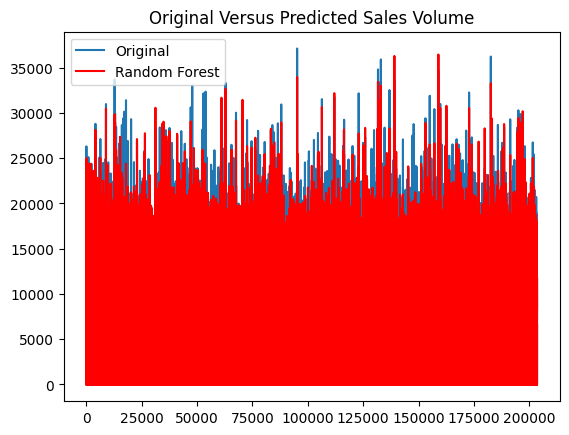

In [0]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the Random Forest model
plt.plot(predictions['RandomForest'], color='red', label='Random Forest')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

### 2. XGBoost
XGBoost is a machine learning algorithm that uses **gradient boosted decision trees**, a supervised learning boosting algorithm that makes use of gradient descent. Gradient descent is an optimization algorithm that is based on a convex function and tweaks its parameters iteratively to minimize a given function to its local minimum.

![image](https://www.mdpi.com/applsci/applsci-12-07739/article_deploy/html/images/applsci-12-07739-g006.png)

In [0]:
def xgboost(X_train, X_test, y_train, y_test):
    # Initialize the XGBoost model with 100 trees, a maximum depth of 10, and the squared error objective
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        objective='reg:squarederror',
    )
    # Fit the XGBoost model to the training data
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    # Predict the target values for the test data
    xgb_predictions = xgb_model.predict(X_test)
    # Inverse transform the predictions and the test target values using the postprocess function
    inverse_predictions, inverse_y_test = postprocess(xgb_predictions, y_test, target_scaler)
    # Evaluate the model's performance and store the results
    results['XGBoost'] = evaluate(inverse_y_test, inverse_predictions)
    predictions['XGBoost'] = inverse_predictions
    return xgb_model, inverse_y_test

xgb_model, inverse_y_test = xgboost(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

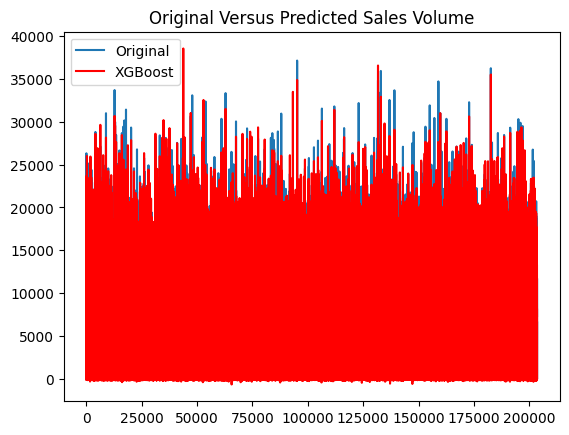

In [0]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the XGBoost model
plt.plot(predictions['XGBoost'], color='red', label='XGBoost')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

## III. Building Deep Learning Models with TensorFlow

Deep learning is a subset of machine learning that uses **multilayered neural networks**, called deep neural networks, to simulate the complex decision-making power of the human brain. 


### 1. Deep Neural Network
A Deep Neural Network (DNN) is a type of **artificial neural network** (ANN) with multiple layers between the input and output layers. These networks are called "deep" because they have more than one hidden layer. DNNs are capable of modeling complex patterns in data and are the foundation of many modern machine learning applications.

![image](https://th.bing.com/th/id/R.7d2cfc39ea511a57412eb39a45036511?rik=heSy6iRM6EWR6Q&pid=ImgRaw&r=0)


In [0]:
def dnn(X_train, X_test, y_train, y_test):
    # Build the neural network model
    dnn_model = Sequential()
    dnn_model.add(Input(shape=(X_train.shape[1],)))  # Explicit Input layer
    dnn_model.add(Dense(128, activation='relu'))
    dnn_model.add(Dense(64, activation='relu'))
    dnn_model.add(Dense(32, activation='relu'))
    dnn_model.add(Dense(1, activation='linear'))
    # Compile the model
    dnn_model.compile(optimizer='adam', loss='mean_absolute_error')
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Fit the DNN model to the training data
    history = dnn_model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    # Evaluate the model
    loss = dnn_model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    # Predict the target values for the test data
    dnn_predictions = dnn_model.predict(X_test)
    # Inverse transform the predictions and the test target values using the postprocess function
    inverse_predictions, inverse_y_test = postprocess(dnn_predictions, y_test, target_scaler)
    # Evaluate the model's performance and store the results
    results['DNN'] = evaluate(inverse_y_test, inverse_predictions)
    predictions['DNN'] = inverse_predictions
    return dnn_model, inverse_y_test, history

dnn_model, inverse_y_test, history = dnn(X_train, X_test, y_train, y_test)

Epoch 1/70


2024-07-25 16:24:29.518168: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33852676 exceeds 10% of free system memory.


 6572/20345 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.2526

*** WARNING: max output size exceeded, skipping output. ***

6358/6358 ━━━━━━━━━━━━━━━━━━━━ 5s 845us/step - loss: 0.2135
Test Loss: 0.21372202038764954
6358/6358 ━━━━━━━━━━━━━━━━━━━━ 6s 914us/step


In [0]:
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,485 (142.52 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,324 (95.02 KB)

Text(0.5, 1.0, 'Original Versus Predicted Sales Volume')

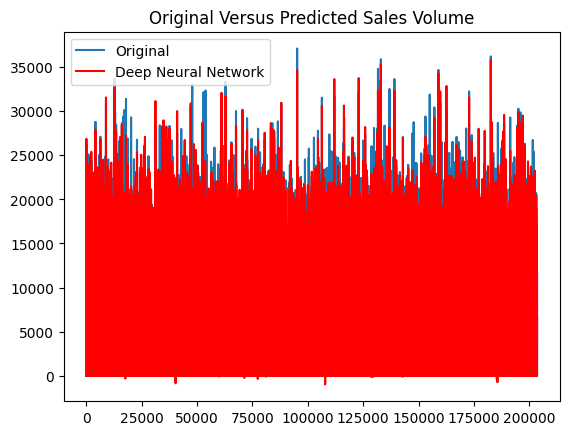

In [0]:
# Plot the original test target values
plt.plot(inverse_y_test, label='Original')
# Plot the predictions from the DNN model
plt.plot(predictions['DNN'], color='red', label='Deep Neural Network')
# Add a legend to the plot to differentiate between the original and predicted values
plt.legend()
plt.title('Original Versus Predicted Sales Volume')

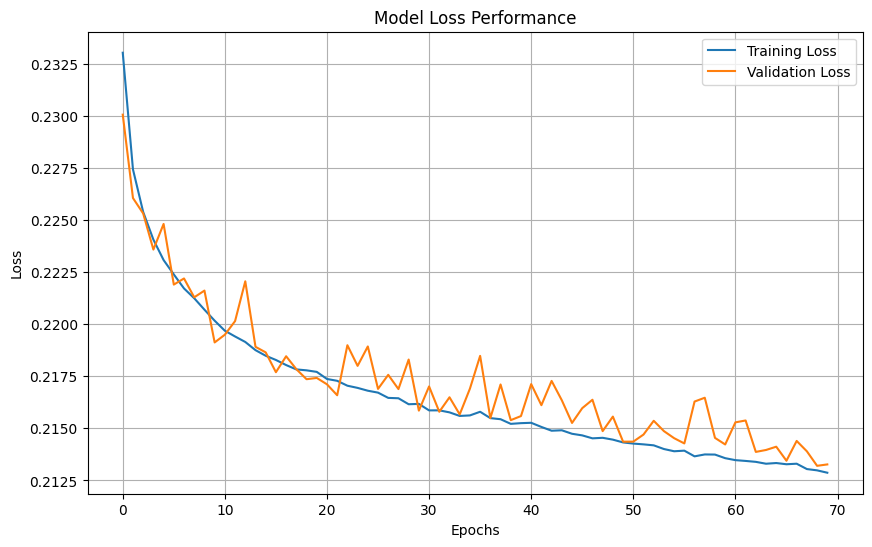

In [0]:
# Plotting the loss performance
plt.figure(figsize=(10, 6))
# Plot the training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
# Plot the validation loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Add a grid to the plot for better readability
plt.grid(True)
plt.show()

## III. Model Evaluation
Model evaluation is the process of using some metrics to **analyze the performance of the model**. It is important in machine learning because it determines the best-performing models, increases accuracy, prevents overfitting, helps achieve organizational goals, and prevents risks

In [0]:
# Loop over each model and print its corresponding metrics
for model, metrics in results.items():
    print(model)
    for metric in metrics:
        print(f'{metric}:{metrics[metric]}')
    print("\n")

RandomForest
mae:839.0077004639388
mse:1550425.4113368588
rmse:1245.160797381952
bias:-9.296495536522453


XGBoost
mae:563.2876425186515
mse:743350.8741321377
rmse:862.1779828620873
bias:-5.383313051294947


DNN
mae:822.8152915405167
mse:1552000.0997931352
rmse:1245.79296024385
bias:54.24378537685338




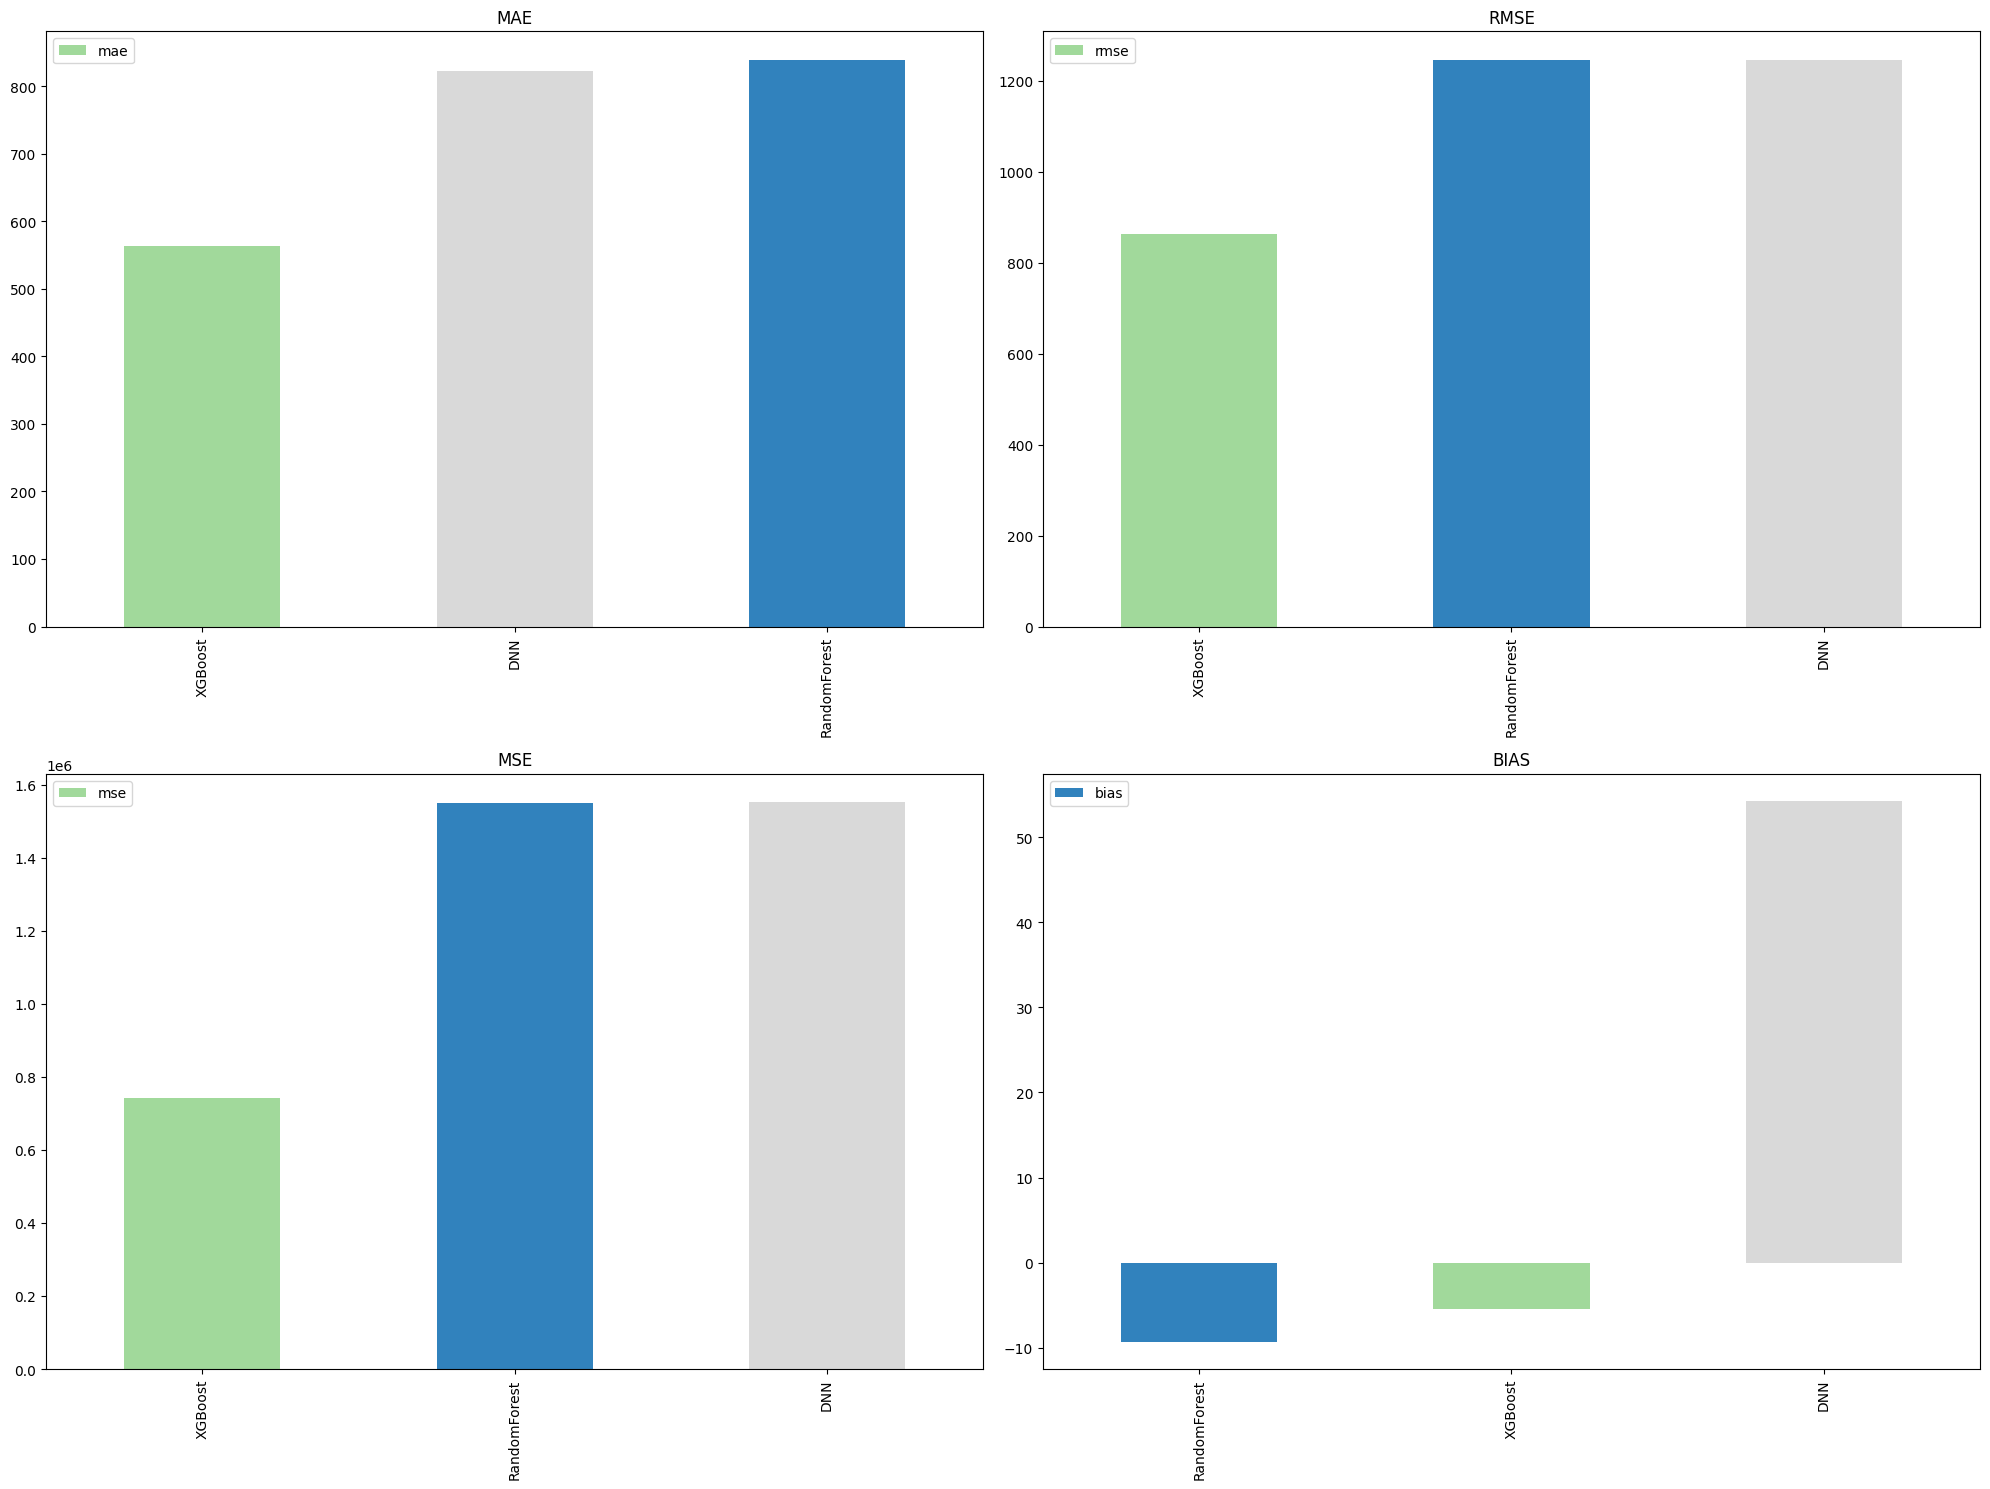

In [0]:
# Flatten the nested arrays in the results dictionary
def flatten_results(results):
    flattened = {}
    for model, metrics in results.items():
        flattened[model] = {metric: value[0] if isinstance(value, np.ndarray) else value for metric, value in metrics.items()}
    return flattened

def plot_bar_metrics(results, metrics=["mae", "rmse", "mse", "bias"]):
    # Flatten the results dictionary
    flattened_results = flatten_results(results)
    # Convert the flattened results dictionary to a DataFrame
    df = pd.DataFrame.from_dict(flattened_results)
    # Get the default color cycle from Matplotlib
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Create a color palette with a specified number of colors
    pallette = plt.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    # Create a dictionary mapping each column to a color
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))
    # Initialize the subplot index
    idx = 1
    # Loop through each metric in the metrics list
    for metric in metrics:
        # Add a subplot to the figure
        fig.add_subplot(2, 2, idx)
        # Plot the sorted values of the metric as a bar chart
        df.loc[metric].sort_values().plot(
            kind="bar",
            color=[color_dict.get(x, "#333333") for x in df.loc[metric].sort_values().index],
        )
        plt.legend()
        # Set the title of the plot to the uppercase metric name
        plt.title(metric.upper())
        # Increment the subplot index
        idx += 1
    plt.tight_layout()
    plt.show()
plot_bar_metrics(results)

## V. Appendix

### 1. Ensemble Models

Ensemble models are a machine learning approach that **combines multiple models** in the prediction process. These models are referred to as **base estimators**.

In [0]:
# Define the models to use for feature selection
models = {
    'RandomForest': rf_model,
    'XGBoost': xgb_model,
}

# Define the number of top features to evaluate
num_features_list = [10, 50, 100]

In [0]:
def select_features(models, X_train, X_test, y_train, y_test):
    # Loop through each model in the models dictionary
    for model_name, model in models.items():
        # Loop through each number of top features to evaluate
        for num_features in num_features_list:
            # Select the top features from the model
            selector = SelectFromModel(model, prefit=True, threshold=-np.inf, max_features=num_features)
            X_train_selected_features = selector.transform(X_train)
            X_test_selected_features = selector.transform(X_test)
            # Define the final model with optimized parameters
            final_model = xgb.XGBRegressor(
                learning_rate=0.05,
                n_estimators=100,
                max_depth=10,
                min_child_weight=1,
                gamma=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='reg:squarederror',
                nthread=4,
                scale_pos_weight=1,
                seed=27,
                reg_alpha=0.1,
                reg_lambda=1.0,
                verbosity=1
            )
            # Fit the final model on the selected features of the training data
            final_model.fit(X_train_selected_features, y_train, eval_set=[(X_test_selected_features, y_test)], verbose=False)
            # Predict the target variable for the test data
            y_pred = final_model.predict(X_test_selected_features)
            # Inverse transform the predictions and the test target values using the postprocess function
            inverse_predictions, inverse_y_test = postprocess(y_pred, y_test, target_scaler)
            # Evaluate the model's performance and store the results
            results[(model_name, num_features)] = evaluate(inverse_y_test, inverse_predictions)
            predictions[(model_name, num_features)] = inverse_predictions

select_features(models, X_train, X_test, y_train, y_test)

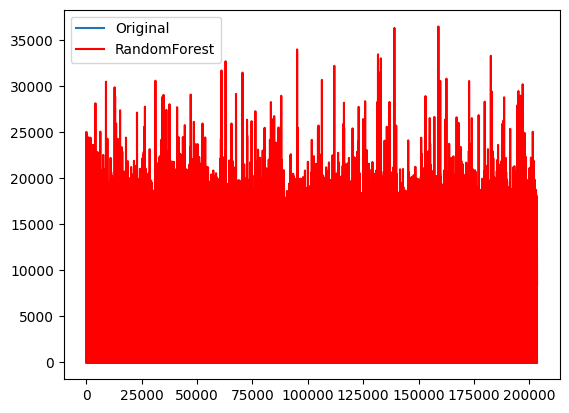

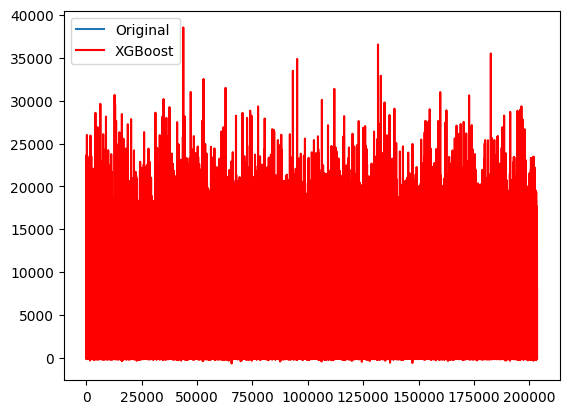

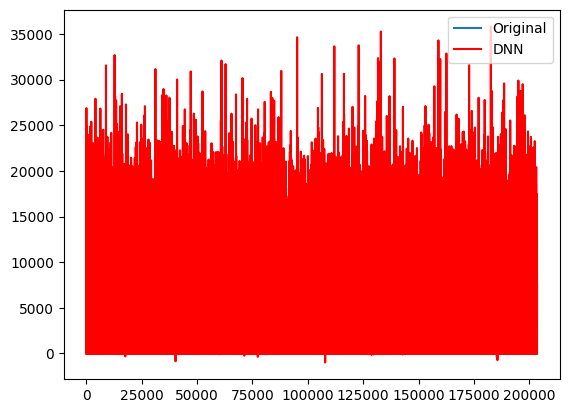

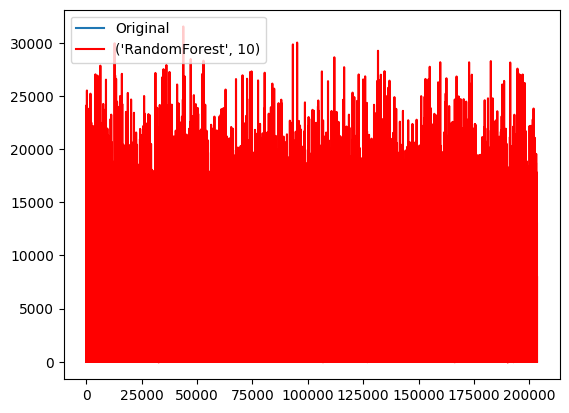

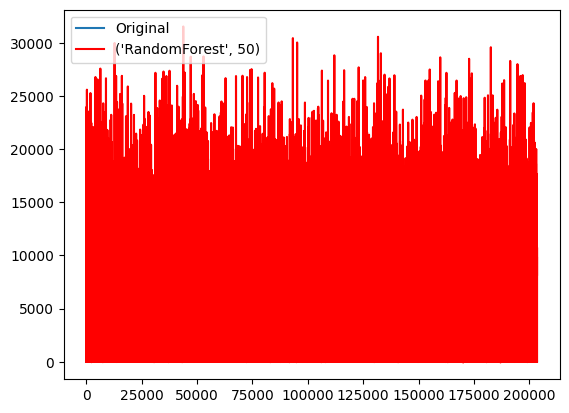

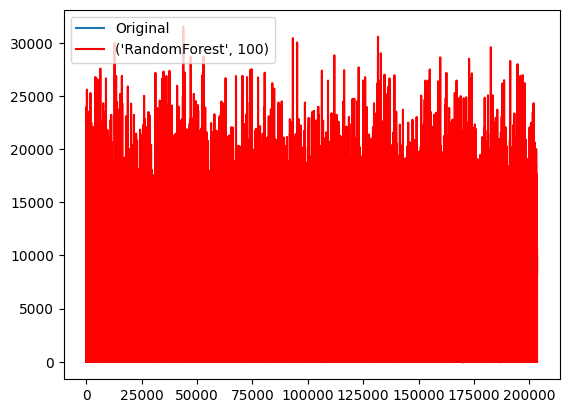

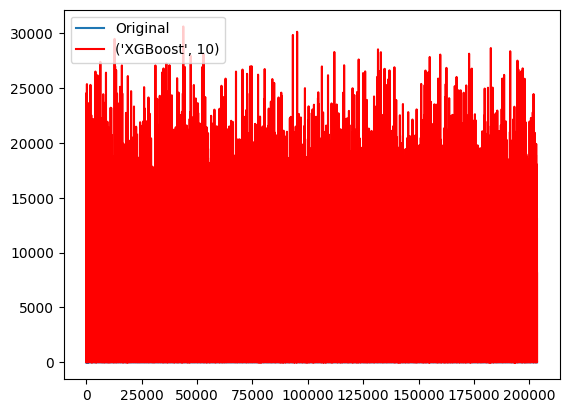

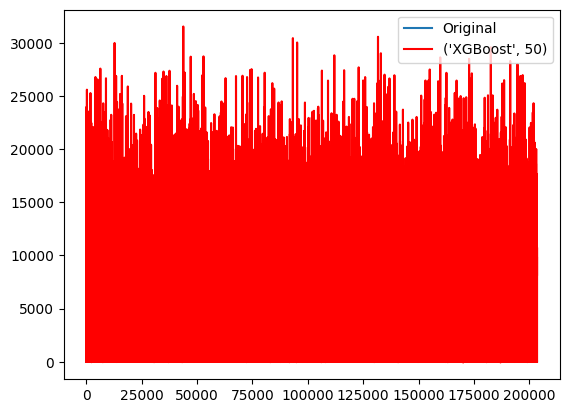

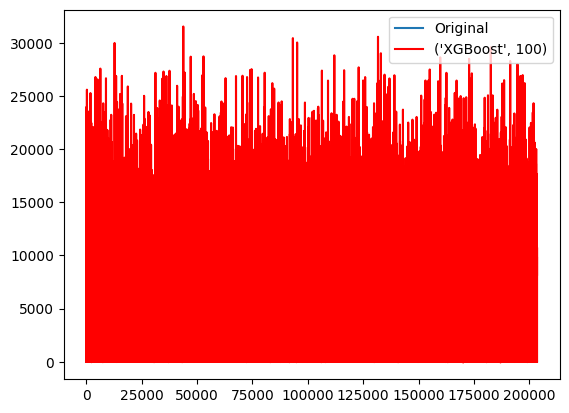

In [0]:
# Loop through each model and its corresponding predictions in the selected_predictions
for model, y_pred in predictions.items():
    plt.figure()
    plt.plot(y_test, label='Original')
    plt.plot(predictions[model], color='red', label=model)
    plt.legend()

In [0]:
# Loop over each model and print its corresponding metrics
for model, metrics in results.items():
    print(model)
    for metric in metrics:
        print(f'{metric}:{metrics[metric]}')
    print("\n")

RandomForest
mae:839.0077004639388
mse:1550425.4113368588
rmse:1245.160797381952
bias:-9.296495536522453


XGBoost
mae:563.2876425186515
mse:743350.8741321377
rmse:862.1779828620873
bias:-5.383313051294947


DNN
mae:822.8152915405167
mse:1552000.0997931352
rmse:1245.79296024385
bias:54.24378537685338


('RandomForest', 10)
mae:710.775325074834
mse:1074236.609603979
rmse:1036.453862747387
bias:-7.752606455512918


('RandomForest', 50)
mae:703.8469134145716
mse:1055593.4563654521
rmse:1027.4207786323245
bias:-7.713301540637618


('RandomForest', 100)
mae:703.8469134145716
mse:1055593.4563654521
rmse:1027.4207786323245
bias:-7.713301540637618


('XGBoost', 10)
mae:707.837797248904
mse:1066172.1913383638
rmse:1032.5561444000823
bias:-7.969671968628682


('XGBoost', 50)
mae:703.8469134145716
mse:1055593.4563654521
rmse:1027.4207786323245
bias:-7.713301540637618


('XGBoost', 100)
mae:703.8469134145716
mse:1055593.4563654521
rmse:1027.4207786323245
bias:-7.713301540637618




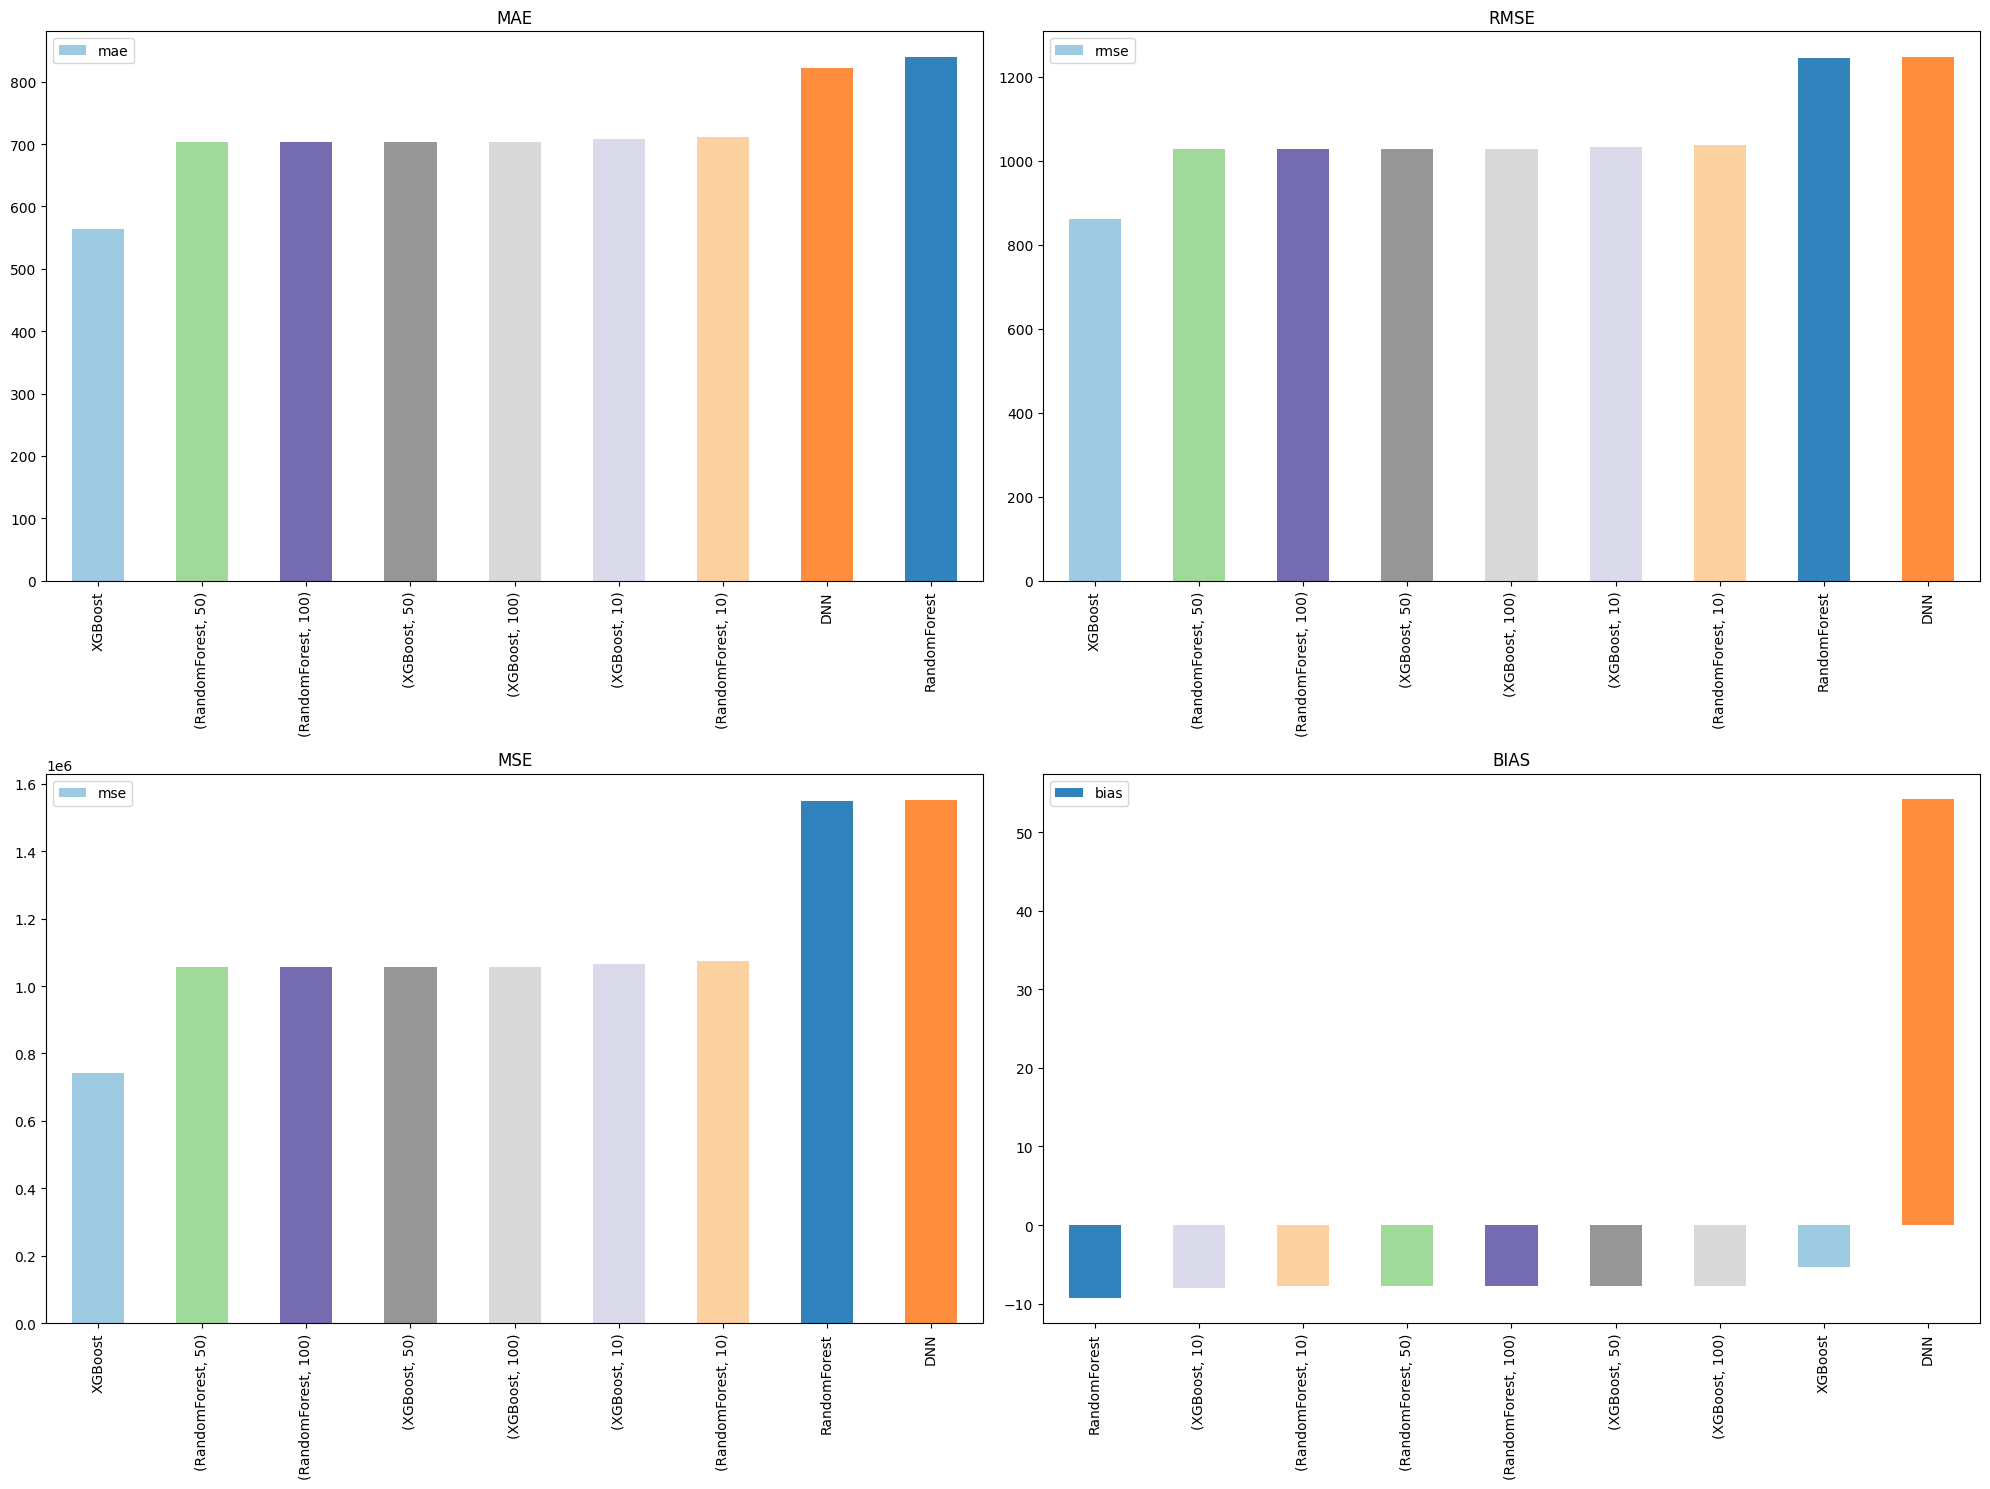

In [0]:
plot_bar_metrics(results)

###  2. Statistical Tests for Feature Selection

#### Pearson Correlation Coefficient
Pearson Correlation Coefficient, often denoted as `r`, measures the strength and direction of a **linear relationship **between two continuous variables. It ranges from -1 to 1, where:

- `r==1` denotes a perfect positive linear relationship
- `r==-1` denotes a perfect negative linear relationship
- `r==0` denotes no relationship at all

In [0]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_significance(df, target_column, dependent_columns):
    # Prepare the result list
    results = []

    # Extract the target values
    target_values = pd.to_numeric(df[target_column], errors='coerce')

    for column in dependent_columns:
        if column != target_column:
            # Extract the dependent variable values
            dependent_values = pd.to_numeric(df[column], errors='coerce')

            # Drop NaN values
            valid_indices = target_values.notna() & dependent_values.notna()
            target_clean = target_values[valid_indices]
            dependent_clean = dependent_values[valid_indices]

            # Calculate Pearson correlation and p-value
            correlation, p_value = pearsonr(target_clean, dependent_clean)

            # Append the result as a tuple (Metric, Correlation, P-Value)
            results.append((column, correlation, p_value))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Metric', 'Correlation', 'P-Value'])

    # Return the DataFrame sorted by absolute correlation value in descending order
    return results_df.sort_values(by='Correlation', key=abs, ascending=False)

# Assuming your data is loaded in a DataFrame called df
dependent_columns = [
    "Customers", "Open", "DayOfWeek", "Promo", "SchoolHoliday", "Month",
    "Year", "Day", "Store",
]
target_column = 'Sales'

# Call the function
significance_df = calculate_significance(df, target_column, dependent_columns)

# Print the DataFrame (optional, if you want to see it in the console)
print(significance_df)

          Metric  Correlation        P-Value
0      Customers     0.894711   0.000000e+00
1           Open     0.678472   0.000000e+00
2      DayOfWeek    -0.462125   0.000000e+00
3          Promo     0.452345   0.000000e+00
4  SchoolHoliday     0.085124   0.000000e+00
5          Month     0.048768   0.000000e+00
6           Year     0.023519  2.038777e-124
7            Day    -0.011612   1.109733e-31
8          Store     0.005126   2.338762e-07


#### PCA - Principal Component Analysis
Principal component analysis, or PCA, is a **dimensionality reduction method** that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

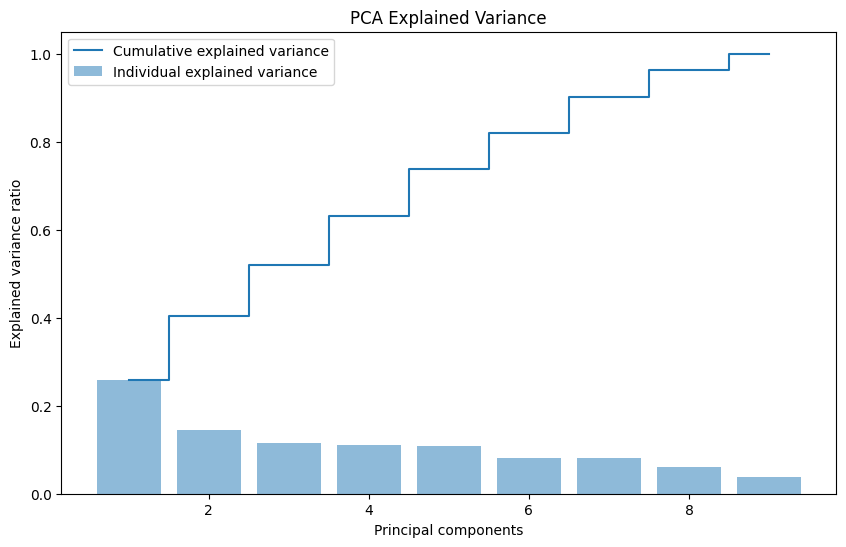

        PC1       PC2       PC3       PC4  ...       PC7       PC8       PC9  Sales
0  1.955980 -0.590619 -0.588087 -0.498170  ...  0.857531  1.819650  0.288058  12918
1  1.152052 -0.564827 -0.645578 -0.616475  ...  0.745664  1.036326 -0.573047   5558
2  0.607777 -1.311447 -1.286018 -0.249703  ...  0.255876  0.282180 -0.537749   6687
3  1.350915 -0.571191 -0.631221 -0.580356  ...  0.773309  1.229840 -0.360250   7543
4  1.239527 -0.567611 -0.639134 -0.594120  ...  0.757799  1.121210 -0.479641   5645

[5 rows x 10 columns]
Explained Variance Ratio by each Principal Component:
PC1: 0.2581
PC2: 0.1447
PC3: 0.1163
PC4: 0.1113
PC5: 0.1075
PC6: 0.0823
PC7: 0.0805
PC8: 0.0617
PC9: 0.0375


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca(df, dependent_columns, target_column):
    # Extract the features (independent variables)
    X = df[dependent_columns]

    # Standardize the features
    X_standardized = StandardScaler().fit_transform(X)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(X_standardized)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(dependent_columns))])

    # Add the target variable to the DataFrame
    pca_df[target_column] = df[target_column]

    # Explained variance
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.title('PCA Explained Variance')
    plt.show()

    return pca_df, explained_variance

dependent_columns = [
    "Customers", "Open", "DayOfWeek", "Promo", "SchoolHoliday", "Month",
    "Year", "Day", "Store",
]
target_column = 'Sales'

# Call the function
pca_df, explained_variance = perform_pca(df, dependent_columns, target_column)

# Display the first few rows of the PCA result DataFrame
print(pca_df.head())

# Display explained variance for each principal component
print("Explained Variance Ratio by each Principal Component:")
for i, var in enumerate(explained_variance):
    print(f'PC{i+1}: {var:.4f}')

#### Dimension Reduction
Dimensionality reduction is a technique used to **reduce the number of input variables** in your dataset. In essence, it simplifies the complexity without losing the essence of the information.

In [0]:
# Standardize the features
X = df[dependent_columns]
X_standardized = StandardScaler().fit_transform(X)

# Perform PCA with all components to get the loadings
pca = PCA()
pca.fit(X_standardized)

# Get the loadings
loadings = pca.components_.T

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=dependent_columns)

# Select the top 4 principal components
top_components_loadings = loadings_df[['PC1', 'PC2', 'PC3', 'PC4']]

# Display the loadings for the top 4 principal components
print(top_components_loadings)


                    PC1       PC2       PC3       PC4
Customers      0.507292 -0.016271  0.036316  0.076577
Open           0.540588 -0.034608  0.115677  0.023897
DayOfWeek     -0.509838 -0.000877 -0.039286  0.048479
Promo          0.402965 -0.098321 -0.299514 -0.031682
SchoolHoliday  0.164146  0.287423  0.242173 -0.146019
Month          0.026335  0.685695 -0.098428  0.018068
Year          -0.004081 -0.653612  0.169946 -0.038979
Day           -0.018992  0.094165  0.892426  0.012134
Store          0.009440  0.001994  0.020143  0.983309
